# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека (достичь MAE менее 8). В вашем распоряжении набор фотографий людей с указанием возраста.

План по выполнению проекта
- Проведем исследовательский анализ набора фотографий.
- Подготовим данные к обучению.
- Обучим нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
labels = pd.read_csv('https://code.s3.yandex.net/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='https://code.s3.yandex.net/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Размер выборки

In [ ]:
labels.shape

(7591, 2)

In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


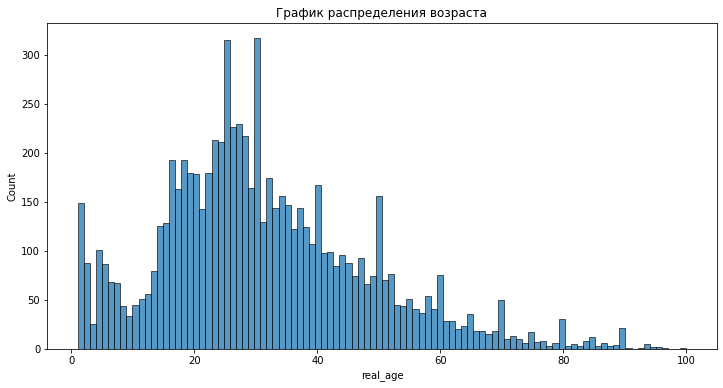

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(labels.real_age, kde=False, bins=100)
plt.title("График распределения возраста")
plt.show()

In [ ]:
labels.real_age.value_counts().head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

Распределение возраста в датасете похоже на реальную картину, за исключением провала в районе 10 лет. На распределение наблюдаются выбросы в районах 25, 30, 40, 50, 60 и т.д. лет, возможно это связано с окгруглением возраста при подготовки данных.

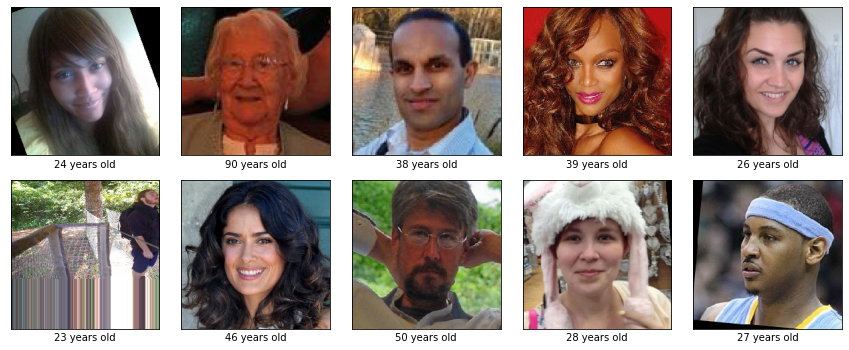

In [ ]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(12,12))
for i in range(10):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.xlabel(f'{target[i]} years old')

<b>Вывод:</b>
1) В датасете есть старые и черно-белые фотографии. Имеет смысл делать аугментацию с тем, чтобы делать фотографию черно-белой в некотором проценте случаев (нету в стандартном наборе). Возможно, стоит подкрутить цветовые каналы или яркость

2) В датасете есть фотогарафи, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл делать аугментацию с rotation_range равным +-15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение так и объект отдельно от фона

3) В датасете есть фотогарафи, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев

4) В датасете есть фотогарафи с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев

5) В датасете есть фотогарафи, на которых изображены не лица, а голова и часть туловища (иногда человек послностью). Имеет смысл делать аугментацию с обезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица примерно одного масштаба


## Обучение модели

In [ ]:
def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

**Результат работы модели:**

Train for 190 steps, validate for 48 steps

Epoch 1/10

190/190 - 123s - loss: 214.7904 - mae: 10.5103 - val_loss: 879.5848 - val_mae: 24.6572

Epoch 2/10

190/190 - 41s - loss: 60.2167 - mae: 5.8565 - val_loss: 850.8814 - val_mae: 24.1458

Epoch 3/10

190/190 - 41s - loss: 29.7570 - mae: 4.2210 - val_loss: 313.4272 - val_mae: 13.1318

Epoch 4/10

190/190 - 42s - loss: 20.5417 - mae: 3.5217 - val_loss: 101.1391 - val_mae: 7.6770

Epoch 5/10

190/190 - 41s - loss: 17.0119 - mae: 3.1338 - val_loss: 83.6585 - val_mae: 7.1848

Epoch 6/10

190/190 - 43s - loss: 14.5783 - mae: 2.9636 - val_loss: 71.6392 - val_mae: 6.3024

Epoch 7/10

190/190 - 66s - loss: 11.6783 - mae: 2.6006 - val_loss: 94.3002 - val_mae: 7.3575

Epoch 8/10

190/190 - 58s - loss: 9.5682 - mae: 2.3602 - val_loss: 66.0102 - val_mae: 6.2099

Epoch 9/10

190/190 - 64s - loss: 8.0766 - mae: 2.1313 - val_loss: 67.0421 - val_mae: 6.0855

Epoch 10/10

190/190 - 72s - loss: 6.7391 - mae: 1.9435 - val_loss: 62.7418 - val_mae: 5.9424

WARNING:tensorflow:sample_weight modes were coerced from

  ...
    to  
  ['...']
  
48/48 - 9s - loss: 62.7418 - mae: 5.9424

Test MAE: 5.9424

## Анализ обученной модели

В ходе проекта был проведен исследовательский анализ предоставленных данных, определены особенности данных. Дообучена ResNet50. В среднем модель допускает ошибку в 6 лет, что удовлетворяет условию задачи - достичь MAE менее 8, и дейсвтительно явлется неплохим показателем, сопоставимым, а возможно и превосходящим возможности человека.
Однако, такая точность работы модели подходит только под первую задачу заказчика (определение возрастной группы для анализа и рекламы товаров), под вторую задачу - добросовестности кассиров при продаже алкоголя, она не подходит, для этой задачи, на мой взгляд, необхима точность по MAE не более 1.